# Tutorial for the ParametricSequencer

The ParametricSequencer is a virtual instrument that facilitates the control of an AWG. The basic principle of the sequencer is that it takes a single template element that is defined with symbols as introduced in PR90 in broadbean and creates a sequence from it by replicating it for different values for selected symbols. For example a template element could define a rectangular pulse with a certain amplitude defined through the symbol 'amplitude'. For given setpoints `('amplitude', [0.1, 0.2, 0.3])`  the parametric sequencer would create a sequence of three elements, all being rectangular pulses but with the given different amplitudes.

### Sequence Parameters
Furthermore one can use a template element that has further symbols, like 'pulse_duration' in the aforementioned example. These symbols become available as qcodes parameters and can be get and set. When setting one of those parameters the sequence gets updated and reuploaded.

### Repeat Modes and Setpoint Parameters
The sequencer can be operated in three different `repeat_mode`s: 'sequence', 'element', and 'inner'.

In sequence mode the whole sequence is repeated. In 'element' mode, only a single element is repeated. For the selection of the repeated element the sequence the sequencer also provides qcodes parameters. Here a 'set'-command does not cause a reupload but simply a jump to the element that relises the requeseted parameters (more precisely: to the element that has a value closest to the requested value).
The 'inner' mode is not implemented yet. It is relevant when we have two sets of setpoints, whose tensor product defines the parameter grid and we want to repeat a certain row of inner setpoints in that space.

### AWG interface
The communication with the awgs is abstracted into an awg interface. This notebook can be run without an AWG present by using the SimulatedAWGInterface that simply plots the resulting actions. For real instruments, so far there is only an interface for a AWG5014.

## Example
Lets take a look at some example code.

To run the example you also need Braodbean PR90 and if you want to use the AWG5014 you will also need the qcodes PR1167

Lets first setup the AWG and the interface:

In [1]:
real_instrument_present = False

In [2]:
import numpy as np
from copy import copy
from lomentum import Segment, SegmentGroup, Element, Sequence
from lomentum.atoms import sine, ramp, flat, zero, marker_on, marker_off
from lomentum.plotting import plotter

from qdev_wrappers.customised_instruments.parametric_sequencer import ParametricSequencer
from qdev_wrappers.customised_instruments.awg_interface import AWG5014Interface, SimulatedAWGInterface
from qcodes import Instrument

In [3]:
if real_instrument_present:
    from qdev_wrappers.station_configurator import StationConfigurator
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
    awg.clock_freq(1e7)    
    awg_int = AWG5014Interface(awg=awg)
else:
    awg_int = SimulatedAWGInterface()

The following example uses a template element similar to the one used in the Broadbean (v1) Tutorial. It produces a centered pi pulse and a marker with a given delay:

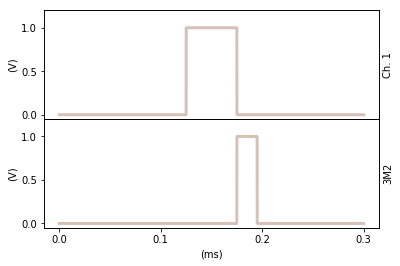

In [4]:
seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude='pulse_amplitude')
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration='total_duration')

m1 = marker_off(duration='pre_marker_time')
m2 = marker_on(duration='marker_time')
m3 = marker_off(duration='post_marker_time')

markers = SegmentGroup(m1, m2, m3,
                       duration='total_duration')

def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
    context['pre_marker_time'] = context['flex_time'] + context['marker_delay']
    context['post_marker_time'] = context['total_duration'] - context['marker_time'] - context['pre_marker_time']

template_element = Element(segments={1: pi_pulse,
                                     '3M2': markers},
                           sequencing={'nrep':2},
                           transformation=mytransformation)

context = {'total_duration': 3e-4,
           'marker_time': 2e-5,
           'marker_delay': 5e-5,
           'pulse_duration': 0.5e-4,
           'pulse_amplitude': 1}

pulse_durations = np.linspace(0e-4,2.9e-4,3)

inner_setpoints = ('pulse_duration', pulse_durations)

plotter(template_element, context=context, SR=awg_int.get_SR())

As setpoints we want to use the pulse duration. The marker (lower row) will be automatically adjusted.

Next, let us create the ParametricSequencer providing it with the awg interface, the template, the setpoints and the context:

In [5]:
try:
    ps = Instrument.find_instrument('PS')
    ps.close()
except KeyError:
    pass
ps = ParametricSequencer(name='PS', awg=awg_int)

Lets upload a sequence by calling `change_sequence`:

uploading


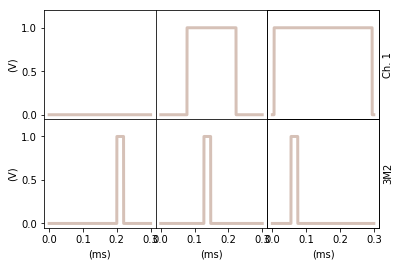

In [6]:
ps.change_sequence(template_element=template_element,
                   context=context,
                   inner_setpoints=inner_setpoints)

As expected we got a sequence with three different pulse durations.

The sequence can be changed in parts:

uploading


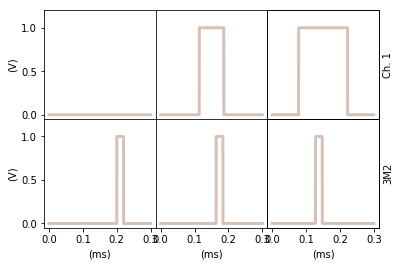

In [8]:
ps.change_sequence(inner_setpoints=('pulse_duration', 0.5*np.linspace(0e-4,2.9e-4,3)))

uploading


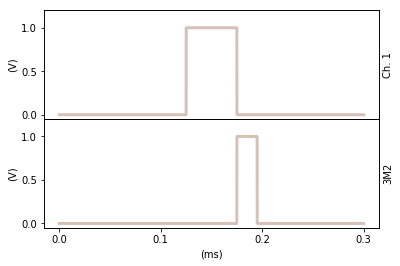

In [9]:
ps._inner_setpoints = None
ps.change_sequence(inner_setpoints=None)

uploading


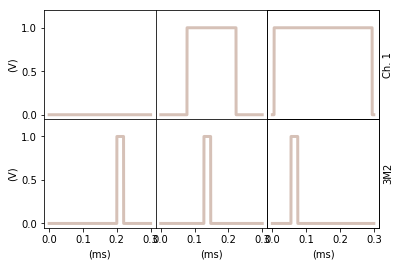

In [10]:
ps.change_sequence(inner_setpoints=inner_setpoints)


### Sequence Parameters

The sequence parameters, as provided in the context, are exposed in the channel 'sequence':

In [11]:
ps.sequence.parameters

{'total_duration': <qcodes.instrument.parameter.Parameter: total_duration at 3116966579672>,
 'marker_time': <qcodes.instrument.parameter.Parameter: marker_time at 3117074156904>,
 'marker_delay': <qcodes.instrument.parameter.Parameter: marker_delay at 3117074154216>,
 'pulse_duration': <qcodes.instrument.parameter.Parameter: pulse_duration at 3117074203088>,
 'pulse_amplitude': <qcodes.instrument.parameter.Parameter: pulse_amplitude at 3117074205384>}

The sequence can be modified via those parameters, for example lets increase the marker duration:

uploading


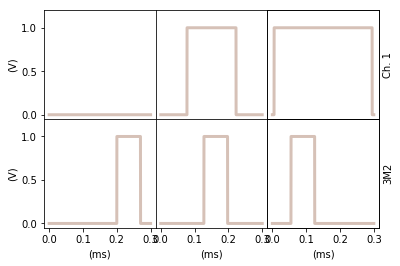

In [12]:
ps.sequence.marker_time(7e-5)

### The single_upload Context Manager

For each change of parameters the sequence is uploaded. To avoid this long process a context manager can be used to have a single upload even though multiple parameters are changed: (only one plot appears)

uploading


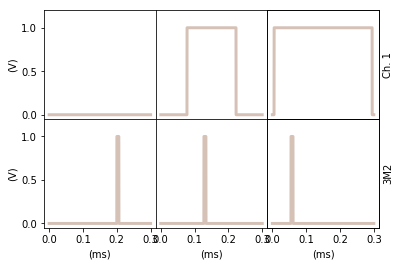

In [13]:
with ps.single_upload():
    ps.sequence.marker_delay(5e-5)
    ps.sequence.marker_time(6e-6)

### Element Repeat Mode

From here one can change to element repeat mode. Without having specified an element, the first element will be repeated:

setting repeated element to 1


c:\users\a-dovoge\repos\lomentum\lomentum\plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])


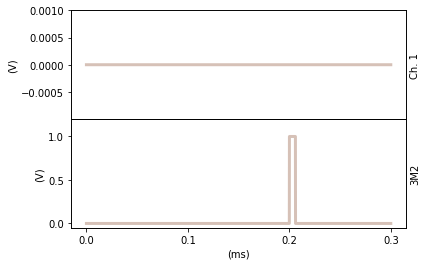

In [14]:
ps.repeat_mode('element')

There is only one parameter available for stepping in the repeat mode for this case (only inner setpoints are defined), which as defined above with the setpoints, is the pulse duration:

In [15]:
ps.repeat.parameters

{'pulse_duration': <qcodes.instrument.parameter.Parameter: pulse_duration at 3117075560936>}

To step to another element the parameter can be set:

c:\users\a-dovoge\repos\qdev-wrappers\qdev_wrappers\customised_instruments\parametric_sequencer.py:378: UserWarning: Rounding setpoint value from 0.0001 to 0.000145.
  warn(f'Rounding setpoint value from {value} to '


setting repeated element to 2


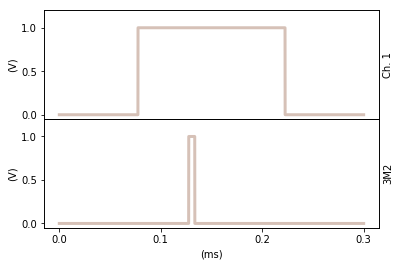

In [16]:
ps.repeat.pulse_duration(0.1e-3)

Switch between sequence mode and element mode remembers the current step:

repeating full series
setting repeated element to 2


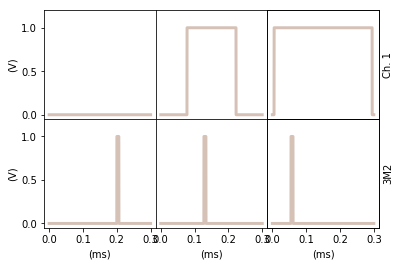

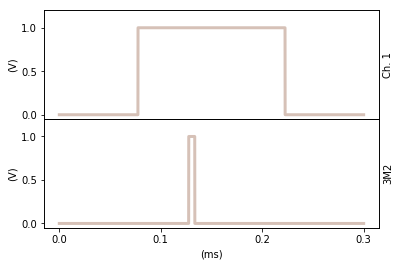

In [17]:
ps.repeat_mode('sequence')
ps.repeat_mode('element')

repeating full series


c:\users\a-dovoge\repos\qdev-wrappers\qdev_wrappers\customised_instruments\parametric_sequencer.py:292: UserWarning: Warning: setting the inner setpoints to while being in sequence mode
  warn(f"Warning: setting the {['outer', 'inner'][set_inner]} "


repeating full series
setting repeated element to 2


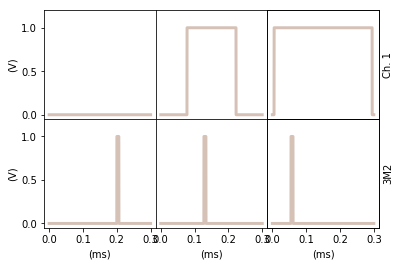

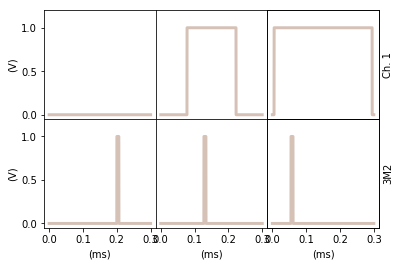

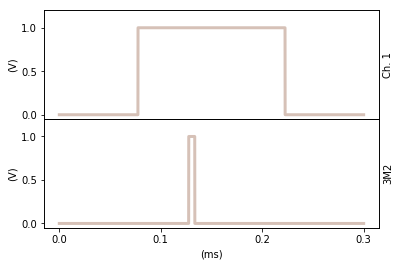

In [18]:
ps.repeat_mode('sequence')
# expect a warning here
ps.repeat.pulse_duration(0.1e-3)
ps.repeat_mode('element')

## 2D sequence
Here is a slightly more complicated example with inner and outer setpoints, resulting into a 2D sequence.
Furthermore an initial segment is specified, that gets prepended to the sequence and is not included in the stepping. There is also another new keyword argument: 'first_element' which enables to specify a different first element of the series (as requested). In contrast to the initial element, will this first element be included in the stepping

In [19]:
seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude='pulse_amplitude')
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration='total_duration')

m1 = marker_off(duration='pre_marker_time')
m2 = marker_on(duration='marker_time')
m3 = marker_off(duration='post_marker_time')

markers = SegmentGroup(m1, m2, m3,
                       duration='total_duration')

def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
    context['pre_marker_time'] = context['flex_time'] + context['marker_delay']
    context['post_marker_time'] = context['total_duration'] - context['marker_time'] - context['pre_marker_time']

template_element = Element(segments={1: pi_pulse,
                                     2: pi_pulse,
                                     '3M2': markers},
                           sequencing={'nrep':2},
                           transformation=mytransformation)
first_element = copy(template_element)
first_element.segments['3M2'] = marker_off(duration='total_duration')


ze = zero(duration='total_duration')
initial_element = Element(segments={1: ze,
                                    2: ze,
                                    '3M2': markers},
                          local_context={'pre_marker_time':5e-5,
                                         'marker_time':2e-5,
                                         'post_marker_time':5e-5,
                                         'total_duration':12e-5})


context = {'total_duration': 3e-4,
           'marker_time': 2e-5,
           'marker_delay': 5e-5,
           'pulse_duration': 0.5e-4,
           'pulse_amplitude': 1}

pulse_durations = np.linspace(0e-4,2.9e-4,3)

inner_setpoints = ('pulse_duration', pulse_durations)
outer_setpoints = ('pulse_amplitude', np.linspace(0.1,1,3))

In [20]:
try:
    ps = Instrument.find_instrument('PS')
    ps.close()
except KeyError:
    pass
ps = ParametricSequencer(name='PS',
                         awg=awg_int,
                         template_element=template_element,
                         first_sequence_element=first_element,
                         initial_element=initial_element,
                         context=context,
                         inner_setpoints=inner_setpoints,
                         outer_setpoints=outer_setpoints)

As expected we see a sequence with 9+1 elements. The very first element only has the marker and the second one is missing the marker.


We can step to an element that is now defined by the set of inner and outer setpoints. Here there is not yet any context manager to minimize the communication overhead and the awg will make 3 steps: (the error messag is due to plotting a signal with zero amplitude)

setting repeated element to 2
setting repeated element to 2
setting repeated element to 3


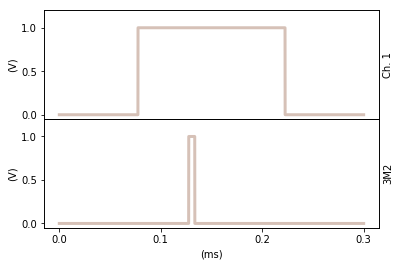

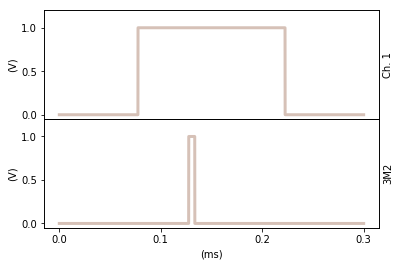

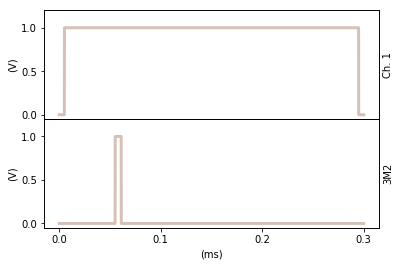

In [21]:
ps.repeat_mode('element')
ps.repeat.pulse_amplitude(outer_setpoints[1][0])
ps.repeat.pulse_duration(inner_setpoints[1][1])

### Setting new setpoints
We can modify the sequence by changing the setpoints:

uploading
setting repeated element to 2


c:\users\a-dovoge\repos\lomentum\lomentum\plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])


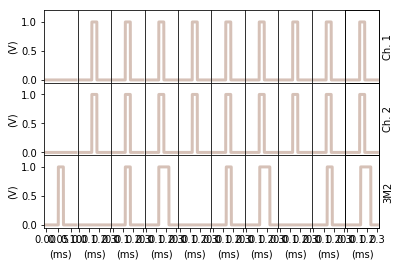

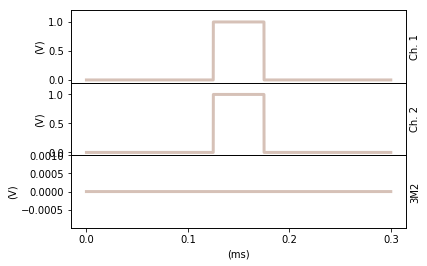

In [23]:
inner_setpoints = ('marker_time', np.linspace(0e-4,1e-4,3))
outer_setpoints = ('marker_delay', np.linspace(0e-4,1e-5,3))
ps.change_sequence(inner_setpoints=inner_setpoints, outer_setpoints=outer_setpoints)

(The first image results from uploading, but the mode stays unchanged as 'element' mode here back at the first element)

It is also possible to load different templates. Everything gets stored in metadata (except for the elements - template, first, initial - , for which the serialization has not been implemented yet).

## Next Steps
The next steps here will be to get the 'inner repeat mode' to work and then consider the possible ways of extending to keyword like paramters, e.g. storing different gates, that can be addressed by their name.
Another extension could be the ability to reprogramm the order of the setpoints without uploading, so that a gate sequence can be created.

I am happy about any kind of feedback!

### Experimental yaml format

There is an experimental feature to create a seqeunce for the sequencer in with a yaml file. Feel free to play around:

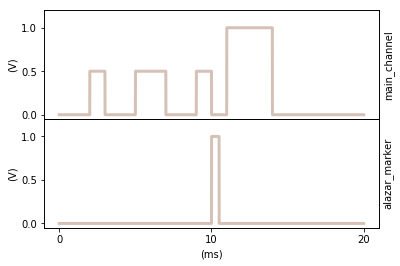

In [24]:
import yaml
from lomentum.plotting import plotter
from lomentum.loader import read_segment, read_element

file = """
 rabi:
    template_element:
        duration: total_duration
        segments:
            main_channel:
                - SegmentGroup:  # driving
                    duration: driving_stage_duration
                    segments:
                        - zero: {duration: initial_wait}
                        - flat: {duration: pi_2, amplitude: pulse_amplitude}
                        - zero: {duration: evolution_time}
                        - flat: {duration: pi, amplitude: pulse_amplitude}
                        - zero: {duration: evolution_time}
                        - flat: {duration: pi_2, amplitude: pulse_amplitude}
                    transformation:
                        type: declarative_linear_transformation
                        data:
                            - pi:
                                - [2, pi_2]
                            - initial_wait:
                                - [1, driving_stage_duration]
                                - [-2, pi_2]
                                - [-1, pi]
                                - [-2, evolution_time]
                - SegmentGroup:  # readout
                    duration: readout_stage_duration
                    segments:
                        - zero: {duration: readout_delay}
                        - flat: {duration: readout_duration, amplitude: readout_amplitude}
                        - zero: {duration: post_readout_duration}
            alazar_marker:
                - marker_off: {duration: driving_stage_duration}
                - marker_pulse:
                    duration: readout_stage_duration
                    delay: pre_marker_duration
                    marker_duration: readout_marker_duration
        transformation:
            type: declarative_linear_transformation
            data:
                - post_readout_duration:
                    - [1, readout_stage_duration]
                    - [-1, readout_delay]
                    - [-1, readout_duration]
                - pre_marker_duration:
                    - [1, readout_delay]
                    - [-1, readout_marker_delay]
"""
yf = yaml.load(file)
e = read_element(yf['rabi']['template_element'])
test_context={'driving_stage_duration': 1e-2,
              'pi_2':1e-3,
              'pulse_amplitude': 0.5,
              'evolution_time':2e-3,
              'readout_stage_duration': 1e-2,
              'readout_delay': 1e-3,
              'readout_duration': 3e-3,
              'readout_amplitude': 1,
              'readout_marker_delay': 1e-3,
              'readout_marker_duration':0.5e-3}
plotter(e, SR=1e6, context=test_context)